In [1]:
from fastai.vision import *

In [2]:
# Load Imagenet Synsets
with open('imagenet/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

# len(synsets)==1001
# sysnets[0] == background
synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

with open('imagenet/imagenet_classes.txt', 'r') as f:
    class_id_to_key = f.readlines()

class_id_to_key = np.array([x.strip() for x in class_id_to_key])

In [3]:
len(class_id_to_key), len(key_to_classname)

(1000, 1861)

In [4]:
classes = [key_to_classname[key] for key in class_id_to_key]

In [5]:
len(classes), classes

(1000,
 ['tench, Tinca tinca',
  'goldfish, Carassius auratus',
  'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
  'tiger shark, Galeocerdo cuvieri',
  'hammerhead, hammerhead shark',
  'electric ray, crampfish, numbfish, torpedo',
  'stingray',
  'cock',
  'hen',
  'ostrich, Struthio camelus',
  'brambling, Fringilla montifringilla',
  'goldfinch, Carduelis carduelis',
  'house finch, linnet, Carpodacus mexicanus',
  'junco, snowbird',
  'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
  'robin, American robin, Turdus migratorius',
  'bulbul',
  'jay',
  'magpie',
  'chickadee',
  'water ouzel, dipper',
  'kite',
  'bald eagle, American eagle, Haliaeetus leucocephalus',
  'vulture',
  'great grey owl, great gray owl, Strix nebulosa',
  'European fire salamander, Salamandra salamandra',
  'common newt, Triturus vulgaris',
  'eft',
  'spotted salamander, Ambystoma maculatum',
  'axolotl, mud puppy, Ambystoma mexicanum',
  'bullfrog, 

In [6]:
data_bunch = ImageDataBunch.single_from_classes('', classes,
        ds_tfms=get_transforms(), size=299).normalize(imagenet_stats)

In [7]:
learn = cnn_learner(data_bunch, models.resnet152, pretrained=True)

In [9]:
learn.data.single_from_classes??

In [8]:
learn.export('export/export.pkl')

In [9]:
learn = load_learner('export')

In [10]:
img = open_image('uploaded/26168066_1561304567310234_7022864506612690269_n.jpg')

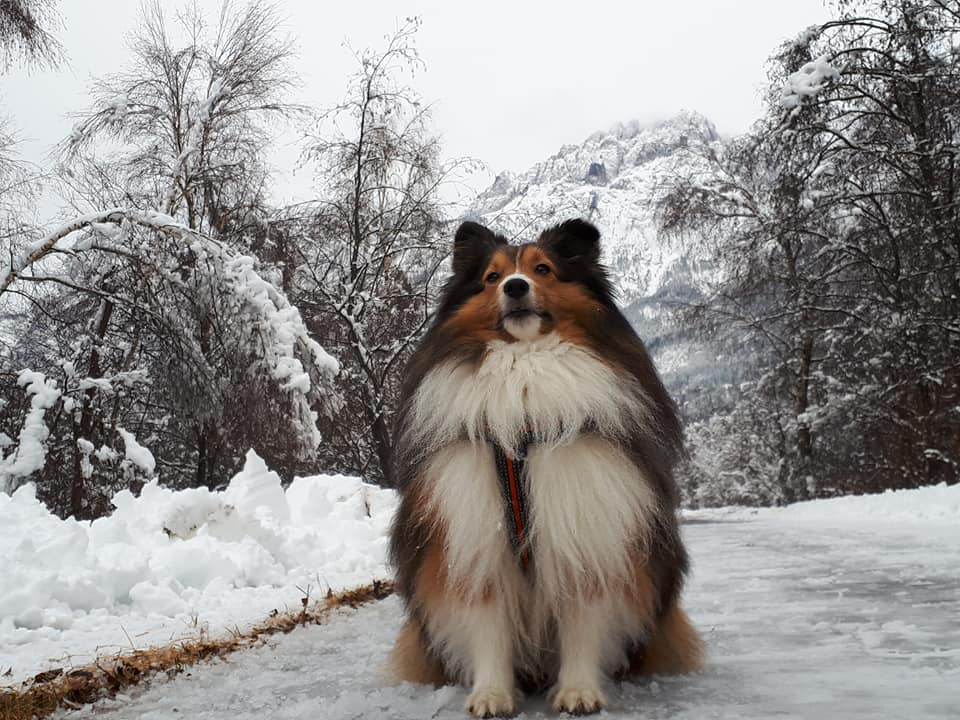

In [11]:
img

In [12]:
cl, label, prob = learn.predict(img)

In [23]:
cl

Category damselfly

In [13]:
len(prob)

1000

In [14]:
label

tensor(320)

In [15]:
prob.shape

torch.Size([1000])

In [16]:
class_keys = class_id_to_key[label]

In [17]:
class_keys

'n02268853'

In [18]:
class_names = key_to_classname[class_keys]

In [19]:
class_names

'damselfly'